In [4]:
import re
import os
import glob
import linecache
import itertools
import shutil
from pprint import pprint
import itertools

import pandas as pd
import matplotlib as mt
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.stats as stats

from rdkit import Chem
import rdkit.Chem.Recap as Recap
from rdkit.Chem import AllChem

from pymol import cmd, stored

import mmtf

from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import itertools

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

In [ ]:
os.chdir('/home/angel/Documents/angel/experiments/Cumarin_targets/Docking/Results/')
files=[]
scores=[]
for file in glob.glob("*.mol2"):
    try:
        with open(file,'rt') as f:
            modes=[]
            for i, line in enumerate(f):
                if 'Gold.Score' in line:
                    score=float(linecache.getline(file,i+3).strip().split(' ')[0])
                    modes.append (score)

            if max(modes) >=0:
                files.append (file.split('.')[0])
                scores.append(max(modes))
    except Exception:
        pass
d={ 'Name':pd.Series(files),
    'Score':pd.Series(scores)}
table=pd.DataFrame (d)
sort =table.sort_values ('Score',ascending=False)
sort = sort.reset_index(drop=True)

In [ ]:
sort.head()

In [ ]:
print (len (sort))
sort.to_csv ('../Analysis/all_scores.csv')

In [ ]:
max(sort['Score'])

In [ ]:
h=list(sort ['Score'])
h.sort()
hmean = np.mean(h)
hstd = np.std(h)

plt.rcParams['axes.linewidth'] = 1.5
pdf = stats.norm.pdf(h, hmean, hstd)
plt.figure(figsize=(8,6))

plt.plot(h,pdf,'k--',linewidth=2.0)
plt.hist(h,density=True,histtype='step',color='gray',linewidth=1.5)
plt.title ('Distribution of probability',fontsize=14,fontweight='bold',family='sans-serif')
plt.xlabel ('Score',fontsize=12,fontweight='bold')
plt.ylabel ('Probability',fontsize=12,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.axvline(x=hmean+(3.5*hstd),color='r',linewidth=1,linestyle='--',)
plt.tight_layout()
plt.savefig('../Analysis/distribution_of_probability.svg',dpi=600,format='svg',transparent=False)
plt.show()

In [ ]:
best=[]
worst=[]
for score in h:
    if score > hmean + (3.5*hstd):
        best.append(score)
    else:
        worst.append (score)

In [ ]:
len(best)

In [ ]:
candidates=[]
for i in range(len(best)):
    candidates.append ((sort.at [i,'Name'], sort.at [i,'Score']))

targets=pd.DataFrame(candidates,columns=['Name','Score'])
targets=targets.set_index (targets['Name'])
targets=targets.drop (columns='Name')

In [ ]:
single=[t.split('_')[0] for t in targets.index]

In [ ]:
s=list(set (single))

In [ ]:
len(s)

In [ ]:
pdb_id=[]
title=[]
classification=[]
sequence=[]
method=[]
resolution=[]
date=[]
for pdb_code in list(targets.index):
    data=mmtf.fetch (pdb_code.split('_')[0])
    pdb_id.append (data.structure_id)
    title.append (data.title)
    classification.append (data.entity_list[0]['description'])
    sequence.append (data.entity_list[0]['sequence'])
    method.append (data.experimental_methods[0])
    resolution.append (data.resolution)
    date.append (data.release_date)

targets['PDB_id'] = pd.Series(pdb_id, index=targets.index)
targets['Classification'] = pd.Series(classification, index=targets.index)
targets['Title'] = pd.Series(title, index=targets.index)
targets['Sequence'] = pd.Series(sequence, index=targets.index)
targets['Method'] = pd.Series(method, index=targets.index)
targets['Resolution'] = pd.Series(resolution, index=targets.index)
targets['Release_date'] = pd.Series(date, index=targets.index)
o=[x.lower() for x in targets['Classification']]
targets['Classification']=pd.Series(o,targets.index)

In [ ]:
targets.to_csv('../Analysis/best_of_docking.csv')

In [ ]:
p_folder='../Out_Proteins/'
l_folder='../Results/'
c_folder='../Analysis/Complexes/'


for tar in list(targets.index):
    print (tar)
    cmd.load (l_folder+tar+'.mol2',object='lig',state=0,finish=1)
    cmd.select ('dummy', 'not name C,H,O,N,P,S')
    cmd.remove('dummy')
    cmd.load (p_folder+tar.split('_')[0]+'.mol2',object='prot')
    cmd.select ('enabled')
    cmd.save(filename=c_folder+tar+'.pdb',selection='sele', state=-1,format='pdb')
    cmd.deselect()
    cmd.delete('all')

In [ ]:
f= open('../Analysis/Complexes/input_dpocket.txt',"w+")
for tar in targets.index:
    line=(tar+'.pdb\tLIG1L\n')
    f.write (line)
f.close() 

In [ ]:
pockets_folder='../Analysis/Pockets/'
for file in os.listdir (c_folder):
    if '.txt' in file:
        shutil.move (c_folder+file,pockets_folder+file)

In [7]:
cavities='../Analysis/Pockets/dpout_explicitp.txt'

In [8]:
lines_list = open(cavities).read().splitlines()
results=[]
for line in lines_list:
    line=line.split (' ')
    while '' in line:
        line.remove('')
    results.append (line)    
table=pd.DataFrame(data=results[1:],columns=results[0])

In [18]:
table['pdb']=[i.split('.')[0] for i in table['pdb']]

In [19]:
table.head()

,pdb,lig,overlap,PP-crit,PP-dst,crit4,crit5,crit6,crit6_continue,lig_vol,...,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
0,3Q3J_1,LIG1L,100.00,1,0.00,1.00,1.00,1,2.00,117.28,...,0,2,0,0,2,1,4,0,3,2
1,4RFQ_1,LIG1L,100.00,1,0.00,1.00,1.00,1,2.00,138.33,...,1,0,0,0,2,2,1,1,2,1
2,5NWG_1,LIG1L,100.00,1,0.00,1.00,1.00,1,2.00,110.96,...,0,1,1,2,1,2,0,0,3,0
3,2JGB_1,LIG1L,100.00,1,0.00,1.00,1.00,1,2.00,129.25,...,0,1,1,0,1,3,1,2,1,1
4,2FL5_1,LIG1L,100.00,1,0.00,1.00,1.00,1,2.00,160.71,...,0,1,0,1,1,1,0,0,5,1


In [20]:
table.to_csv ('../Analysis/table_cavities_explicit.csv')

# Pocket clustering

In [21]:
cavities=pd.read_csv('../Analysis/table_cavities_explicit.csv')
cavities=cavities.set_index(cavities['pdb'])
cavities=cavities.drop(columns=['Unnamed: 0','pdb'])

In [22]:
cavities.head()

,lig,overlap,PP-crit,PP-dst,crit4,crit5,crit6,crit6_continue,lig_vol,pock_vol,...,LEU,LYS,MET,PHE,PRO,SER,THR,TRP,TYR,VAL
pdb,,,,,,,,,,,,,,,,,,,,,
3Q3J_1,LIG1L,100.0,1,0.0,1.0,1.0,1,2.0,117.28,815.43,...,0,2,0,0,2,1,4,0,3,2
4RFQ_1,LIG1L,100.0,1,0.0,1.0,1.0,1,2.0,138.33,523.71,...,1,0,0,0,2,2,1,1,2,1
5NWG_1,LIG1L,100.0,1,0.0,1.0,1.0,1,2.0,110.96,556.23,...,0,1,1,2,1,2,0,0,3,0
2JGB_1,LIG1L,100.0,1,0.0,1.0,1.0,1,2.0,129.25,1266.47,...,0,1,1,0,1,3,1,2,1,1
2FL5_1,LIG1L,100.0,1,0.0,1.0,1.0,1,2.0,160.71,693.82,...,0,1,0,1,1,1,0,0,5,1


In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [24]:
cavities_std = cavities.loc[:,['lig_vol','pock_vol','mean_as_solv_acc', 'apol_as_prop', 'mean_loc_hyd_dens',
                                         'hydrophobicity_score', 'volume_score', 'polarity_score','charge_score', 'prop_polar_atm']].values
cavities_std = StandardScaler().fit_transform(cavities_std)

In [25]:
pca = PCA()
pca.fit(cavities_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [26]:
cavities_2d = pca.transform(cavities_std)

In [27]:
cavities_pca= pd.DataFrame(cavities_2d)
cavities_pca.index = cavities.index
cavities_pca.columns = ['PC{}'.format(i+1) for i in range(len(cavities_pca.columns))]
cavities_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
pdb,,,,,,,,,,
3Q3J_1,2.697644,-0.167719,1.739355,0.161721,-1.056702,-0.208216,0.218814,0.725872,0.409294,-0.107183
4RFQ_1,0.360096,1.512264,2.452983,-1.053893,1.724766,-0.292059,-0.003888,-0.256735,0.095522,0.063986
5NWG_1,-1.344189,0.083913,0.751082,-1.005849,-2.012675,0.918224,0.536942,0.225241,-0.141940,-0.059175
2JGB_1,1.541078,-2.653224,0.620965,1.590241,-0.142602,-0.976996,0.934919,-0.263579,0.452946,-0.371467
2FL5_1,-2.143532,-0.343997,0.072286,-0.302497,2.799141,0.188942,-0.227272,-1.089042,-0.014115,-0.292581


In [28]:
print(pca.explained_variance_ratio_) 
print(sum(pca.explained_variance_ratio_))

[0.32071771 0.1521088  0.13545683 0.12431599 0.09766725 0.0622355
 0.04103081 0.03074303 0.02467294 0.01105114]
1.0000000000000002


[]

<Figure size 576x432 with 0 Axes>

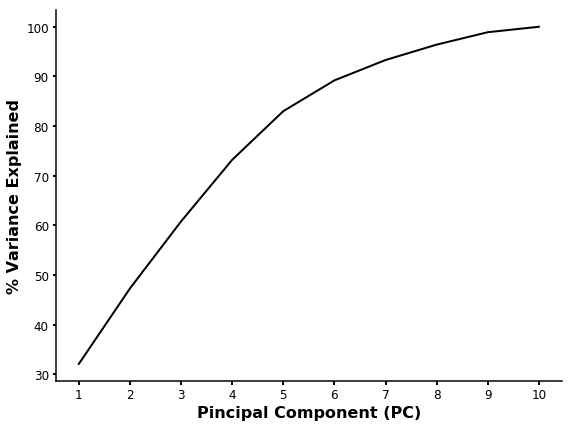

In [29]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot([i+1 for i in range(len(var))],var,'k-',linewidth=2)
plt.xticks([i+1 for i in range(len(var))])
plt.ylabel('% Variance Explained',fontsize=16,fontweight='bold')
plt.xlabel('Pincipal Component (PC)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.tick_params ('both',width=2,labelsize=12)
plt.plot()

## Normalization of PC1-PC4 for clustering analysis

In [30]:
scale1 = 1.0/(max(cavities_pca['PC1']) - min(cavities_pca['PC1']))
scale2 = 1.0/(max(cavities_pca['PC2']) - min(cavities_pca['PC2']))
scale3 = 1.0/(max(cavities_pca['PC3']) - min(cavities_pca['PC3']))
scale4 = 1.0/(max(cavities_pca['PC4']) - min(cavities_pca['PC4']))

cavities_pca['PC1_normalized']=[i*scale1 for i in cavities_pca['PC1']]
cavities_pca['PC2_normalized']=[i*scale2 for i in cavities_pca['PC2']]
cavities_pca['PC3_normalized']=[i*scale3 for i in cavities_pca['PC3']]
cavities_pca['PC4_normalized']=[i*scale4 for i in cavities_pca['PC4']]

### PC1 vs PC2 analysis

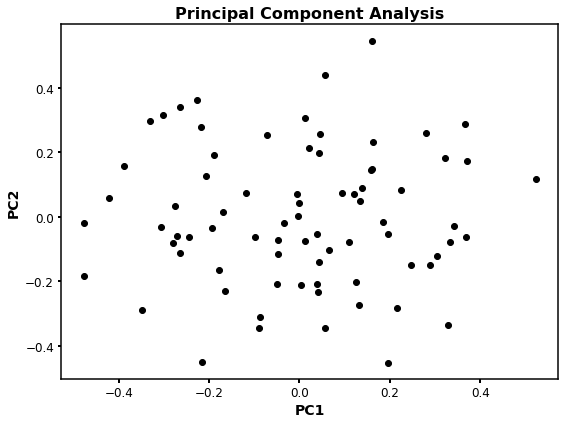

In [31]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(cavities_pca['PC1_normalized'],cavities_pca['PC2_normalized'],'o',color='k')
ax.set_title ('Principal Component Analysis',fontsize=16,fontweight='bold',family='sans-serif')
ax.set_xlabel ('PC1',fontsize=14,fontweight='bold')
ax.set_ylabel ('PC2',fontsize=14,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=12)

#for i, name in enumerate(cavities_pca.index):
    #    ax.annotate(name, (cavities_pca.iloc[i].PC2, cavities_pca.iloc[i].PC1),color='k')\n",

plt.tight_layout()
plt.show()

Silhouette score for k-means clustering

For n_clusters = 2 The average silhouette_score is : 0.3304482160911727
For n_clusters = 3 The average silhouette_score is : 0.35213204316919083
For n_clusters = 4 The average silhouette_score is : 0.3409216778240088
For n_clusters = 5 The average silhouette_score is : 0.3458220312250892
For n_clusters = 6 The average silhouette_score is : 0.3421318316162625
For n_clusters = 7 The average silhouette_score is : 0.36923293216146524


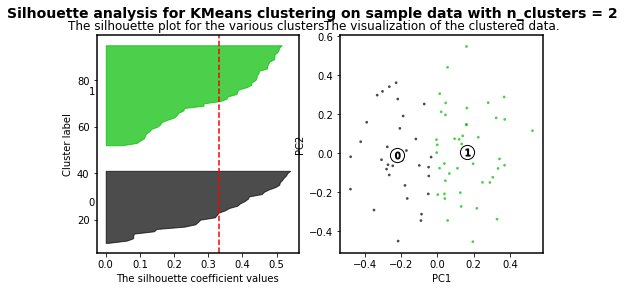

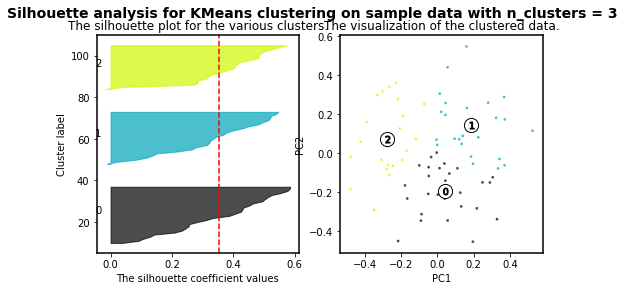

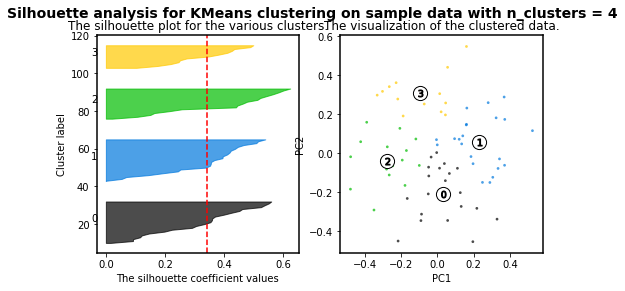

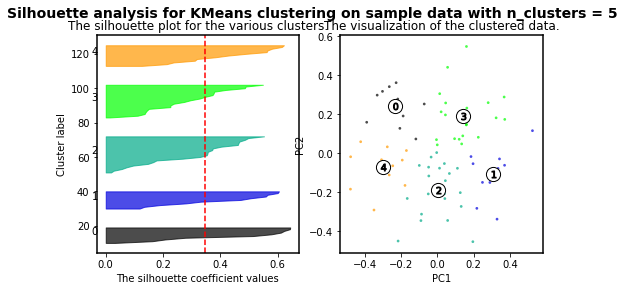

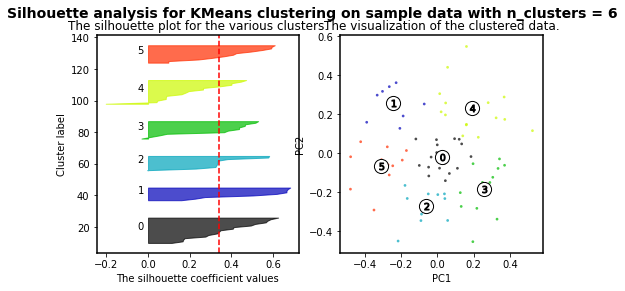

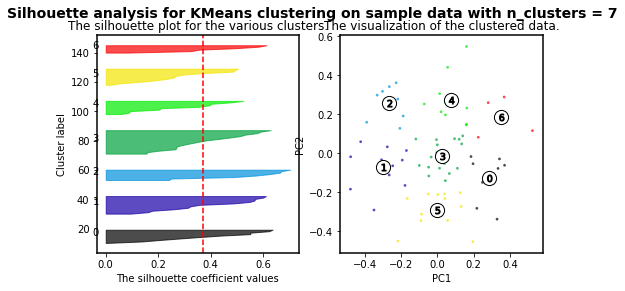

In [32]:
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:
    fig, (ax1,ax2)= plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(cavities_pca[['PC1_normalized','PC2_normalized']])
    silhouette_avg = silhouette_score(cavities_pca[['PC1_normalized','PC2_normalized']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(cavities_pca[['PC1_normalized','PC2_normalized']], cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(cavities_pca['PC1_normalized'], cavities_pca['PC2_normalized'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [33]:
kmeans = KMeans(n_clusters=4, random_state=10)
clusters = kmeans.fit(cavities_pca[['PC1_normalized','PC2_normalized']])

In [34]:
cavities_pca['Cluster_PC1_PC2'] = pd.Series(clusters.labels_, index=cavities.index)

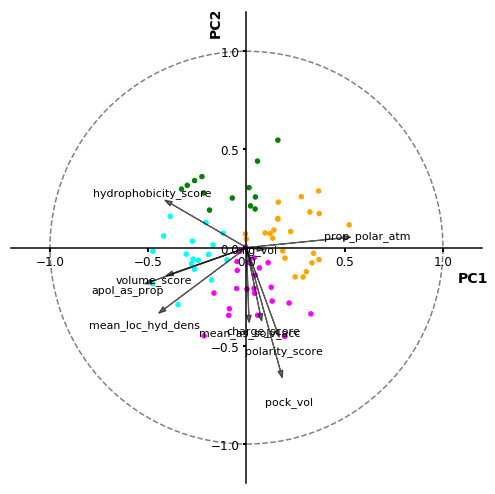

In [35]:
plt.rcParams['axes.linewidth'] = 1.5


color_code={ 0:        'magenta',\
            1.0:   'orange',\
            2.0:      'cyan',\
            3.0:           'green',\
            4.0:        'm',\
            5.0:        'y',\
            6.0:        'darkorange',\
            7.0:       'k',\
           }
ax =cavities_pca.plot(
    kind='scatter',
    x='PC1_normalized',y='PC2_normalized',
    c=[color_code[i] for i in cavities_pca.Cluster_PC1_PC2.astype(np.float)], 
    marker='o',
    figsize=(7,7))

#plt.title ('Principal Component Analysis and K-means clustering',fontsize=16,fontweight='bold',family='sans-serif')
plt.xlabel ('PC1',fontsize=14,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('PC2',fontsize=14,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)

plt.tick_params ('both',width=2,labelsize=12)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

lab=['lig_vol','pock_vol','mean_as_solv_acc', 'apol_as_prop', 'mean_loc_hyd_dens',
     'hydrophobicity_score', 'volume_score', 'polarity_score','charge_score', 'prop_polar_atm']

l=np.transpose(pca.components_[0:2, :])

n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.6,linewidth=1.2,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize=11)

circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')
ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.savefig('../Analysis/PC1_vs_PC2.svg',dpi=1200,format='svg',transparent=False)
plt.show()

In [36]:
data=pd.read_csv('../Analysis/best_of_docking.csv')

In [37]:
data=data.set_index(data['Name'],drop=True)
data=data.drop(columns=['Name'])

In [38]:
data.head()

,Score,PDB_id,Classification,Title,Sequence,Method,Resolution,Release_date
Name,,,,,,,,
3Q3J_1,64.61,3Q3J,plexin-a2,Crystal structure of plexin A2 RBD in complex ...,GLIRQQIEYKTLILNCVNPDNENSPEIPVKVLNCDTITQVKEKILD...,X-RAY DIFFRACTION,1.971,2011-01-12
4RFQ_1,63.31,4RFQ,histidine protein methyltransferase 1 homolog,Human Methyltransferase-Like 18,GHKSMENAAPSQDTDSPLSAASSSRNLEPHGKQPSLRAAKEHAMPK...,X-RAY DIFFRACTION,2.400,2014-10-08
5NWG_1,62.09,5NWG,tankyrase-2,Crystal structure of TNKS2 in complex with 7-c...,MHHHHHHSSGVDLGTENLYFQSMLNTSGSGTILIDLSPDDKEFQSV...,X-RAY DIFFRACTION,1.400,2018-03-14
2JGB_1,61.96,2JGB,eukaryotic translation initiation factor 4e ty...,Structure of human eIF4E homologous protein 4E...,GPLHMKAVVPGPAEHPLQYNYTFWYSRRTPGRPTSSQSYEQNIKQI...,X-RAY DIFFRACTION,1.700,2007-02-27
2FL5_1,61.45,2FL5,immunoglobulin igg1 lambda light chain,Cofactor-containing antibodies: Crystal struct...,SYELKQPPSVSVSPGQTARITCSGDVLPKKYAYWYQERSGQAPVLV...,X-RAY DIFFRACTION,3.000,2006-02-21


In [39]:
cavities_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC1_normalized,PC2_normalized,PC3_normalized,PC4_normalized,Cluster_PC1_PC2
pdb,,,,,,,,,,,,,,,
3Q3J_1,2.697644,-0.167719,1.739355,0.161721,-1.056702,-0.208216,0.218814,0.725872,0.409294,-0.107183,0.341302,-0.028614,0.288521,0.030503,1
4RFQ_1,0.360096,1.512264,2.452983,-1.053893,1.724766,-0.292059,-0.003888,-0.256735,0.095522,0.063986,0.045559,0.258006,0.406896,-0.198779,3
5NWG_1,-1.344189,0.083913,0.751082,-1.005849,-2.012675,0.918224,0.536942,0.225241,-0.141940,-0.059175,-0.170065,0.014316,0.124588,-0.189717,2
2JGB_1,1.541078,-2.653224,0.620965,1.590241,-0.142602,-0.976996,0.934919,-0.263579,0.452946,-0.371467,0.194975,-0.452664,0.103004,0.299941,0
2FL5_1,-2.143532,-0.343997,0.072286,-0.302497,2.799141,0.188942,-0.227272,-1.089042,-0.014115,-0.292581,-0.271196,-0.058689,0.011991,-0.057055,2


In [40]:
data=data.join(cavities_pca)

In [41]:
data.head()

,Score,PDB_id,Classification,Title,Sequence,Method,Resolution,Release_date,PC1,PC2,...,PC6,PC7,PC8,PC9,PC10,PC1_normalized,PC2_normalized,PC3_normalized,PC4_normalized,Cluster_PC1_PC2
Name,,,,,,,,,,,,,,,,,,,,,
3Q3J_1,64.61,3Q3J,plexin-a2,Crystal structure of plexin A2 RBD in complex ...,GLIRQQIEYKTLILNCVNPDNENSPEIPVKVLNCDTITQVKEKILD...,X-RAY DIFFRACTION,1.971,2011-01-12,2.697644,-0.167719,...,-0.208216,0.218814,0.725872,0.409294,-0.107183,0.341302,-0.028614,0.288521,0.030503,1
4RFQ_1,63.31,4RFQ,histidine protein methyltransferase 1 homolog,Human Methyltransferase-Like 18,GHKSMENAAPSQDTDSPLSAASSSRNLEPHGKQPSLRAAKEHAMPK...,X-RAY DIFFRACTION,2.400,2014-10-08,0.360096,1.512264,...,-0.292059,-0.003888,-0.256735,0.095522,0.063986,0.045559,0.258006,0.406896,-0.198779,3
5NWG_1,62.09,5NWG,tankyrase-2,Crystal structure of TNKS2 in complex with 7-c...,MHHHHHHSSGVDLGTENLYFQSMLNTSGSGTILIDLSPDDKEFQSV...,X-RAY DIFFRACTION,1.400,2018-03-14,-1.344189,0.083913,...,0.918224,0.536942,0.225241,-0.141940,-0.059175,-0.170065,0.014316,0.124588,-0.189717,2
2JGB_1,61.96,2JGB,eukaryotic translation initiation factor 4e ty...,Structure of human eIF4E homologous protein 4E...,GPLHMKAVVPGPAEHPLQYNYTFWYSRRTPGRPTSSQSYEQNIKQI...,X-RAY DIFFRACTION,1.700,2007-02-27,1.541078,-2.653224,...,-0.976996,0.934919,-0.263579,0.452946,-0.371467,0.194975,-0.452664,0.103004,0.299941,0
2FL5_1,61.45,2FL5,immunoglobulin igg1 lambda light chain,Cofactor-containing antibodies: Crystal struct...,SYELKQPPSVSVSPGQTARITCSGDVLPKKYAYWYQERSGQAPVLV...,X-RAY DIFFRACTION,3.000,2006-02-21,-2.143532,-0.343997,...,0.188942,-0.227272,-1.089042,-0.014115,-0.292581,-0.271196,-0.058689,0.011991,-0.057055,2


In [42]:
data.to_csv('../Analysis/PCA_clustering.csv')

## Read all data and add UniProt info 

In [43]:
cluster=pd.read_csv('../Analysis/PCA_clustering.csv')

In [46]:
cluster=cluster.set_index(cluster['Name'],drop=True)
cluster=cluster.drop(columns=['Name'])

In [48]:
new_data=cluster.drop_duplicates(keep='first')

In [49]:
new_data.head()

,Score,PDB_id,Classification,Title,Sequence,Method,Resolution,Release_date,PC1,PC2,...,PC6,PC7,PC8,PC9,PC10,PC1_normalized,PC2_normalized,PC3_normalized,PC4_normalized,Cluster_PC1_PC2
Name,,,,,,,,,,,,,,,,,,,,,
3Q3J_1,64.61,3Q3J,plexin-a2,Crystal structure of plexin A2 RBD in complex ...,GLIRQQIEYKTLILNCVNPDNENSPEIPVKVLNCDTITQVKEKILD...,X-RAY DIFFRACTION,1.971,2011-01-12,2.697644,-0.167719,...,-0.208216,0.218814,0.725872,0.409294,-0.107183,0.341302,-0.028614,0.288521,0.030503,1
4RFQ_1,63.31,4RFQ,histidine protein methyltransferase 1 homolog,Human Methyltransferase-Like 18,GHKSMENAAPSQDTDSPLSAASSSRNLEPHGKQPSLRAAKEHAMPK...,X-RAY DIFFRACTION,2.400,2014-10-08,0.360096,1.512264,...,-0.292059,-0.003888,-0.256735,0.095522,0.063986,0.045559,0.258006,0.406896,-0.198779,3
5NWG_1,62.09,5NWG,tankyrase-2,Crystal structure of TNKS2 in complex with 7-c...,MHHHHHHSSGVDLGTENLYFQSMLNTSGSGTILIDLSPDDKEFQSV...,X-RAY DIFFRACTION,1.400,2018-03-14,-1.344189,0.083913,...,0.918224,0.536942,0.225241,-0.141940,-0.059175,-0.170065,0.014316,0.124588,-0.189717,2
2JGB_1,61.96,2JGB,eukaryotic translation initiation factor 4e ty...,Structure of human eIF4E homologous protein 4E...,GPLHMKAVVPGPAEHPLQYNYTFWYSRRTPGRPTSSQSYEQNIKQI...,X-RAY DIFFRACTION,1.700,2007-02-27,1.541078,-2.653224,...,-0.976996,0.934919,-0.263579,0.452946,-0.371467,0.194975,-0.452664,0.103004,0.299941,0
2FL5_1,61.45,2FL5,immunoglobulin igg1 lambda light chain,Cofactor-containing antibodies: Crystal struct...,SYELKQPPSVSVSPGQTARITCSGDVLPKKYAYWYQERSGQAPVLV...,X-RAY DIFFRACTION,3.000,2006-02-21,-2.143532,-0.343997,...,0.188942,-0.227272,-1.089042,-0.014115,-0.292581,-0.271196,-0.058689,0.011991,-0.057055,2


In [52]:
import urllib
from bs4 import BeautifulSoup
import linecache
from pprint import pprint

uniprot_id=[]
all_pdbs=[]
organism=[]

url = 'https://www.uniprot.org/uploadlists/'

for name in list(new_data.index):
    try:
        params = {
        'from':'PDB_ID',
        'to':'ACC',
        'format':'txt',
        'query':name.split('_')[0]
        }

        data = urllib.parse.urlencode(params)
        data = data.encode('ascii')
        request = urllib.request.Request(url, data)
        with urllib.request.urlopen(request) as response:
            res = response.read()
            page=BeautifulSoup(res).get_text()
            page=page.splitlines()

        new_data.loc[name,'Uniprot']= page[0].split()[1]

        pdbs=[]
        funtions=[]
        process=[]
        organism=[]
        for line in page:
            if 'OS   ' in line:
                line=line.strip().replace('OS   ','').replace('.','')
                organism.append(line)
                new_data.loc[name,'Organism']=(", ".join(list(set(organism))))
            else:
                pass

            if 'DR   PDB;' in line:
                line=line.strip().replace('DR   ','').replace(';','')
                pdbs.append ((line.split()[1]+':'+line.split()[3]))
                new_data.loc[name,'PDB:Resol']=(", ".join(list(set(pdbs))))
            else:
                pass

            if 'DR   GO; GO:' in line:
                line=line.strip().replace('DR   GO; GO:','').replace(';','').split(':')
                if 'F' in line[0]:
                    funtions.append(line[1])
                    new_data.loc[name,'GO_funtion']=(", ".join(list(set(funtions))))
                else:
                    process.append (line[1])
                    new_data.loc[name,'GO_process']=(", ".join(list(set(process))))
            else:
                pass
    except Exception:
        pass

In [53]:
new_data.head()

,Score,PDB_id,Classification,Title,Sequence,Method,Resolution,Release_date,PC1,PC2,...,PC1_normalized,PC2_normalized,PC3_normalized,PC4_normalized,Cluster_PC1_PC2,Uniprot,Organism,PDB:Resol,GO_process,GO_funtion
Name,,,,,,,,,,,,,,,,,,,,,
3Q3J_1,64.61,3Q3J,plexin-a2,Crystal structure of plexin A2 RBD in complex ...,GLIRQQIEYKTLILNCVNPDNENSPEIPVKVLNCDTITQVKEKILD...,X-RAY DIFFRACTION,1.971,2011-01-12,2.697644,-0.167719,...,0.341302,-0.028614,0.288521,0.030503,1,PLXA2_HUMAN,Homo sapiens (Human),"3Q3J:1.97, 2CLS:2.31, 2REX:2.30",cerebellar granule cell precursor tangential m...,"identical protein binding IEA, GTP binding IBA..."
4RFQ_1,63.31,4RFQ,histidine protein methyltransferase 1 homolog,Human Methyltransferase-Like 18,GHKSMENAAPSQDTDSPLSAASSSRNLEPHGKQPSLRAAKEHAMPK...,X-RAY DIFFRACTION,2.400,2014-10-08,0.360096,1.512264,...,0.045559,0.258006,0.406896,-0.198779,3,MET18_HUMAN,Homo sapiens (Human),4RFQ:2.40,protein-containing complex IDA,"methyltransferase activity IEA, heat shock pro..."
5NWG_1,62.09,5NWG,tankyrase-2,Crystal structure of TNKS2 in complex with 7-c...,MHHHHHHSSGVDLGTENLYFQSMLNTSGSGTILIDLSPDDKEFQSV...,X-RAY DIFFRACTION,1.400,2018-03-14,-1.344189,0.083913,...,-0.170065,0.014316,0.124588,-0.189717,2,NaN,NaN,NaN,NaN,NaN
2JGB_1,61.96,2JGB,eukaryotic translation initiation factor 4e ty...,Structure of human eIF4E homologous protein 4E...,GPLHMKAVVPGPAEHPLQYNYTFWYSRRTPGRPTSSQSYEQNIKQI...,X-RAY DIFFRACTION,1.700,2007-02-27,1.541078,-2.653224,...,0.194975,-0.452664,0.103004,0.299941,0,IF4E2_HUMAN,Homo sapiens (Human),"3U7X:2.10, 3M94:2.05, 1EJH:2.20, 2V8X:2.30, 2V...",cellular response to dexamethasone stimulus IE...,"RNA 7-methylguanosine cap binding IBA, protein..."
2FL5_1,61.45,2FL5,immunoglobulin igg1 lambda light chain,Cofactor-containing antibodies: Crystal struct...,SYELKQPPSVSVSPGQTARITCSGDVLPKKYAYWYQERSGQAPVLV...,X-RAY DIFFRACTION,3.000,2006-02-21,-2.143532,-0.343997,...,-0.271196,-0.058689,0.011991,-0.057055,2,HV307_HUMAN,Homo sapiens (Human),"2FL5:3.00, 5W5M:1.90, 1ADQ:3.15, 4B53:1.80, 4D...","extracellular region TAS, Fc-epsilon receptor ...","immunoglobulin receptor binding IBA, antigen b..."


In [54]:
new_data = new_data.sort_values('PDB:Resol', ascending=False)
new_data = new_data.drop_duplicates(keep='first')

In [55]:
new_data.to_csv('../Analysis/All_data.csv')

## Single models

In [59]:
new_data=pd.read_csv('../Analysis/All_data.csv',index_col='Name')

In [60]:
new_data.head()

,Score,PDB_id,Classification,Title,Sequence,Method,Resolution,Release_date,PC1,PC2,...,PC1_normalized,PC2_normalized,PC3_normalized,PC4_normalized,Cluster_PC1_PC2,Uniprot,Organism,PDB:Resol,GO_process,GO_funtion
Name,,,,,,,,,,,,,,,,,,,,,
6MDW_4,57.88,6MDW,sprt-like domain-containing protein spartan,Mechanism of protease dependent DPC repair,GPGRPQESLSLVDASWELVDPTPDLQALFVQFNDQFFWGQLEAVEV...,X-RAY DIFFRACTION,1.50,2019-04-10,-1.705038,-2.633525,...,-0.215719,-0.449303,-0.081009,0.012092,0,SPRTN_HUMAN,Homo sapiens (Human),"6MDX:1.55, 6MDW:1.50, 5IY4:2.94",positive regulation of protein ubiquitination ...,"metal ion binding IEA, K63-linked polyubiquiti..."
6EK3_11,56.65,6EK3,poly [adp-ribose] polymerase 15,PARP15 CATALYTIC DOMAIN MUTANT (Y598L) IN COMP...,MHHHHHHSSGVDLGTENLYFQSMNLPEHWTDMNHQLFCMVQLEPGQ...,X-RAY DIFFRACTION,1.60,2018-07-25,0.521876,-0.605684,...,0.066027,-0.103335,0.040881,-0.042661,0,PAR15_HUMAN,Homo sapiens (Human),"6EK3:1.60, 3V2B:2.20, 3BLJ:2.20, 3GEY:2.20, 4F...",negative regulation of transcription by RNA po...,"NAD+ binding IMP, protein ADP-ribosylase activ..."
1TG6_104,56.81,1TG6,putative atp-dependent clp protease proteolyti...,Crystallography and mutagenesis point to an es...,MWPGILVGGARVASCRYPALGPRLAAHFPAQRPPQRTLQNGLALQR...,X-RAY DIFFRACTION,2.10,2005-03-22,-2.087777,2.001708,...,-0.264142,0.341509,-0.223385,0.328836,3,CLPP_HUMAN,Homo sapiens (Human),"6DL7:2.00, 6H23:3.09, 6BBA:2.80, 1TG6:2.10","mitochondrial matrix IDA, proteolysis involved...","ATP-dependent peptidase activity IBA, serine-t..."
6BHV_1,56.81,6BHV,poly [adp-ribose] polymerase 1,Human PARP-1 bound to NAD+ analog benzamide ad...,MGSSHHHHHHSSGLVPRGSHMTKSKLPKPVQDLIKMIFGSGSGSGG...,X-RAY DIFFRACTION,2.30,2018-02-28,0.307247,-1.217157,...,0.038872,-0.207658,-0.283977,-0.008303,0,PARP1_HUMAN,Homo sapiens (Human),"5XSR:2.30, 3L3L:2.50, 4UXB:3.22, 4ZZZ:1.90, 5W...",regulation of cellular protein localization IM...,"DNA binding TAS, NAD binding IEA, identical pr..."
5VBN_19,56.38,5VBN,dna polymerase epsilon subunit 2,Crystal Structure of human DNA polymerase epsi...,MAPERLRSRALSAFKLRGLLLRGEAIKYLTEALQSISELELEDKLE...,X-RAY DIFFRACTION,2.35,2017-08-02,1.103159,0.524092,...,0.139570,0.089415,-0.194174,-0.191597,1,DPOE2_HUMAN,Homo sapiens (Human),"5VBN:2.35, 2V6Z:-","DNA repair TAS, G1/S transition of mitotic cel...","DNA-directed DNA polymerase activity TAS, DNA-..."


In [61]:
duplicateRows= new_data[new_data.duplicated('PDB:Resol',keep='first')]

In [62]:
single_models=new_data.drop([i for i in duplicateRows.index], axis=0)

In [63]:
size=len(single_models.index)
hmap=np.empty(shape=(size,size))
for index,i in enumerate(single_models['Sequence']):
    for jndex,j in enumerate(single_models['Sequence']):
        a=i
        b=j
        alignment= pairwise2.align.globalxx(a, b,score_only=True)
        identity=((alignment*100)/len(b))
        hmap[index,jndex]=identity

In [64]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [65]:
linked = linkage(hmap, 'single')
labelList =[i for i in single_models.index]

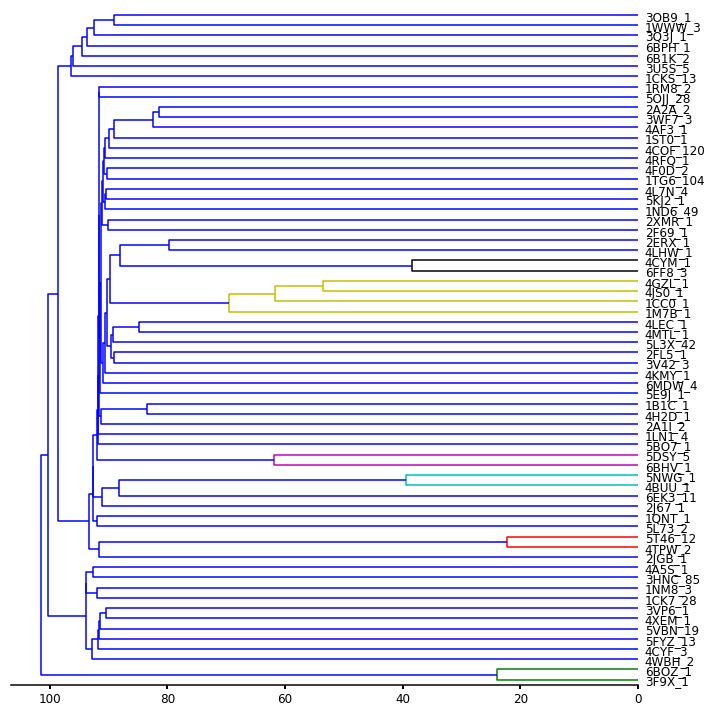

In [66]:
plt.figure(figsize=(10,10))

ax1=plt.subplot()
o=dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tick_params ('both',width=2,labelsize=12)
plt.tight_layout()
plt.savefig('../Analysis/HCL_single_models.svg',dpi=1200,format='svg',transparent=False)
plt.show()  

In [67]:
hcl=pd.DataFrame(list(reversed(o['ivl'])),columns=['Name'])
hcl=hcl.set_index(hcl['Name'], drop=True)

In [68]:
single_models=single_models.loc[list(hcl['Name'])]

In [69]:
single_models.head()

,Score,PDB_id,Classification,Title,Sequence,Method,Resolution,Release_date,PC1,PC2,...,PC1_normalized,PC2_normalized,PC3_normalized,PC4_normalized,Cluster_PC1_PC2,Uniprot,Organism,PDB:Resol,GO_process,GO_funtion
Name,,,,,,,,,,,,,,,,,,,,,
3OB9_1,56.86,3OB9,"male-specific lethal 3-like 1 (drosophila), is...",Structure of the human MSL3 chromo-barrel doma...,GPLGSSASEGMKFKFHSGEKVLCFEPDPTKARVLYDAKIVDVIVGK...,X-RAY DIFFRACTION,2.500,2010-10-13,-2.206879,-0.474430,...,-0.279211,-0.080942,0.202991,-0.328498,2,MS3L1_HUMAN,Homo sapiens (Human),"2Y0N:3.00, 3OB9:2.50, 3OA6:2.35","MSL complex IDA, histone H2A acetylation IBA, ...","methylated histone binding IDA, DNA binding IDA"
1WWW_3,56.08,1WWW,protein (nerve growth factor),NGF IN COMPLEX WITH DOMAIN 5 OF THE TRKA RECEPTOR,SSSHPIFHRGEFSVCDSVSVWVGDKTTATDIKGKEVMVLGEVNINN...,X-RAY DIFFRACTION,2.200,1999-09-15,-2.613466,1.747229,...,-0.330651,0.298093,-0.393270,0.458317,3,NGF_HUMAN,Homo sapiens (Human),"4PMT:2.10, 6D1Z:1.87, 6NSS:1.97, 1SHC:-, 6D20:...","extracellular region TAS, response to axon inj...","protein tyrosine kinase activity IDA, GPI-link..."
3Q3J_1,64.61,3Q3J,plexin-a2,Crystal structure of plexin A2 RBD in complex ...,GLIRQQIEYKTLILNCVNPDNENSPEIPVKVLNCDTITQVKEKILD...,X-RAY DIFFRACTION,1.971,2011-01-12,2.697644,-0.167719,...,0.341302,-0.028614,0.288521,0.030503,1,PLXA2_HUMAN,Homo sapiens (Human),"3Q3J:1.97, 2CLS:2.31, 2REX:2.30",cerebellar granule cell precursor tangential m...,"identical protein binding IEA, GTP binding IBA..."
6BPH_1,57.27,6BPH,at-rich interactive domain-containing protein 4a,Crystal structure of the chromodomain of RBBP1,GEDMEPCLTGTKVKVKYGRGKTQKIYEASIKSTEIDDGEVLYLVHY...,X-RAY DIFFRACTION,1.850,2017-12-20,-3.774275,-1.075698,...,-0.477515,-0.183524,-0.043868,-0.103202,2,ARI4A_HUMAN,Homo sapiens (Human),"2LCC:-, 2YRV:-, 6BPH:1.85, 2MAM:-",regulation of gene expression by genetic impri...,transcription regulatory region DNA binding IB...
6B1K_2,55.63,6B1K,macrophage migration inhibitory factor,Macrophage Migration Inhibitory Factor in Comp...,PMFIVNTNVPRASVPDGFLSELTQQLAQATGKPPQYIAVHVVPDQL...,X-RAY DIFFRACTION,1.170,2018-01-03,-3.766890,-0.103633,...,-0.476581,-0.017681,-0.205102,-0.229696,2,MIF_HUMAN,Homo sapiens (Human),"1P1G:2.50, 4P01:2.07, 3SMC:1.80, 4Z1T:1.50, 4W...","innate immune response IEA, cell surface recep...","phenylpyruvate tautomerase activity IDA, ident..."


In [70]:
single_models.to_csv('../Analysis/single_models_all_data.csv')

In [71]:
size=len(list(single_models.index))
hmap_2=np.empty(shape=(size,size))
for index,i in enumerate(single_models.index):
    for jndex,j in enumerate(single_models.index):
        a=single_models.loc[i].at['Sequence']
        b=single_models.loc[j].at['Sequence']
        alignment= pairwise2.align.globalxx(a, b,score_only=True)
        identity=((alignment*100)/len(b))
        hmap_2[index,jndex]=identity

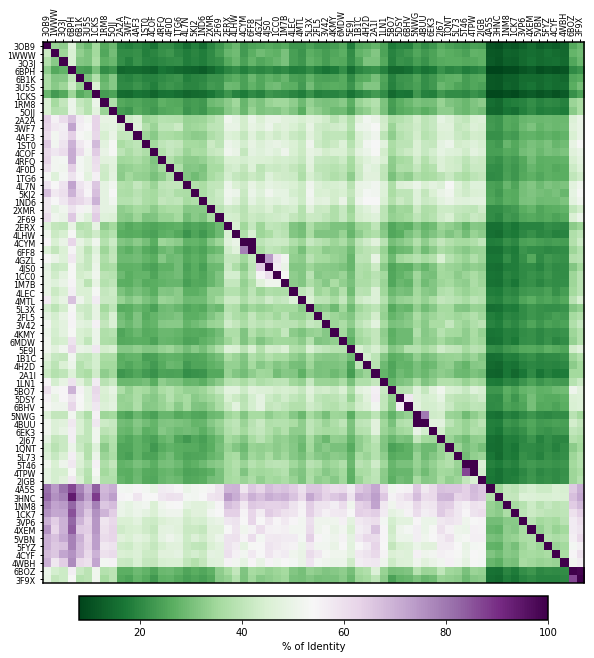

In [78]:
fig, ax = plt.subplots(figsize=(12,12))
plt.imshow (hmap_2,cmap='PRGn_r', interpolation='nearest')
plt.xticks (range(len(single_models.index)),[i.split('_')[0] for i in single_models.index],rotation=90)
plt.yticks (range(len(single_models.index)),[i.split('_')[0] for i in single_models.index])
ax.xaxis.tick_top()
m=plt.colorbar(shrink=0.7,orientation='horizontal',spacing='uniform',pad=0.02)
m.set_label ('% of Identity')
plt.tick_params ('both',width=1,labelsize=8)
#ax1.set_yticklabels (list(reversed(organism_name)))
#ax1.tick_params(direction='out',width=2,labelsize=7)

plt.savefig('../Analysis/hmap.svg',dpi=600,quality=95,format='svg',transparent=False)
plt.show()